In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time
import scipy

In [27]:
import data_loader as dl
import data_transformer as dt
# change this path to match the path of where you have the
# training_50 and validation files
txt_data_path = '/home/mikey/Data/ProteinNet/casp7_txt/'

max_len = None # max len of the protein taken into account
n_angles = 3 # 3 if consider all angles or 2 if only phi and psi

file_name = 'validation'
prim_valid, evo_valid, dih_valid, mask_valid = (dl.parse_primary_from_file(txt_data_path + file_name), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name),
                                                dl.load_file('./'+ file_name + '_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name))

if max_len == None:
    max_len = np.max(np.array([prim.shape[0] for prim in prim_valid]))
    print('max_len set to', max_len)

prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(prim_valid, evo_valid, dih_valid, mask_valid, max_len)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v[:,:,:n_angles]

x_valid.shape, y_valid.shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 224/224 [00:00<00:00, 75970.25it/s]

Grouped 21's together
Loaded data and filtered line endings
Extracted mask data
max_len set to 696
padded
(224,) (269, 20)
padded
(224,) (269, 21)
padded
(224,) (269, 3)
padded
(224,) (269, 1)


((224, 696, 41), (224, 696, 3))

Parsing provided by AlQuraishi

In [149]:
class DataHandler:
    def __init__(self, training_path, percentages, num_epochs):
        self.NUM_AAS = 20
        self.NUM_DIMENSIONS = 3
        
        # choose paths from which to get training data
        self.paths = [training_path + str(perc) + '/*' for perc in percentages]
        print(self.paths)
        
        # load all the file names from these paths
        base_names = self._load_training_paths()
        
        # this queue is taking all the files and asynchronously
        # passes them forward (so that the rest of the computational
        # graph that actually does computation doesn't have to wait for new input)
        self.file_queue = tf.train.string_input_producer(
            tf.convert_to_tensor(base_names),
            num_epochs=num_epochs,
            shuffle=True # not sure if this shuffle works
        )
        
    def _load_training_paths(self):
        base_names = [glob.glob(a_path) for a_path in self.paths]
        base_names = list(np.concatenate(base_names))
        self.training_samples = np.sum([self._get_num_records(file) for file in base_names])
        print("Training samples available", self.training_samples)
        return base_names
    
    def generate_batches(self, batch_size, capacity, max_protein_len=None):
        # dynamic pad makes sure that the length of the proteins
        # is padded to the longest protein in the batch
        id_, one_hot_primary, evolutionary, secondary, tertiary, ter_mask, pri_length, keep = \
            tf.train.batch(
              self.read_protein(self.file_queue, max_length=max_protein_len), 
              batch_size=batch_size, 
              capacity=capacity, 
              dynamic_pad=True
            )
        return id_, one_hot_primary, evolutionary, secondary, tertiary, ter_mask, pri_length, keep
    
    # helper to count number of records in a TF record file
    def _get_num_records(self, tf_record_file):
        return len([x for x in tf.python_io.tf_record_iterator(tf_record_file)])

    def masking_matrix(self, mask, name=None):
        """ Constructs a masking matrix to zero out pairwise distances due to missing residues or padding. 

        Args:
            mask: 0/1 vector indicating whether a position should be masked (0) or not (1)

        Returns:
            A square matrix with all 1s except for rows and cols whose corresponding indices in mask are set to 0.
            [MAX_SEQ_LENGTH, MAX_SEQ_LENGTH]
        """

        with tf.name_scope(name, 'masking_matrix', [mask]) as scope:
            mask = tf.convert_to_tensor(mask, name='mask')

            mask = tf.expand_dims(mask, 0)
            base = tf.ones([tf.size(mask), tf.size(mask)])
            matrix_mask = base * mask * tf.transpose(mask)

            return matrix_mask

    def read_protein(self, filename_queue, max_length, num_evo_entries=21, name=None):
        """ Reads and parses a ProteinNet TF Record. 

            Primary sequences are mapped onto 20-dimensional one-hot vectors.
            Evolutionary sequences are mapped onto num_evo_entries-dimensional real-valued vectors.
            Secondary structures are mapped onto ints indicating one of 8 class labels.
            Tertiary coordinates are flattened so that there are 3 times as many coordinates as 
            residues.

            Evolutionary, secondary, and tertiary entries are optional.

        Args:
            filename_queue: TF queue for reading files
            max_length:     Maximum length of sequence (number of residues) [MAX_LENGTH]. Not a 
                            TF tensor and is thus a fixed value.

        Returns:
            id: string identifier of record
            one_hot_primary: AA sequence as one-hot vectors
            evolutionary: PSSM sequence as vectors
            secondary: DSSP sequence as int class labels
            tertiary: 3D coordinates of structure
            matrix_mask: Masking matrix to zero out pairwise distances in the masked regions
            pri_length: Length of amino acid sequence
            keep: True if primary length is less than or equal to max_length
        """

        with tf.name_scope(name, 'read_protein', []) as scope:
            reader = tf.TFRecordReader()
            _, serialized_example = reader.read(filename_queue)

            context, features = tf.parse_single_sequence_example(serialized_example,
                                    context_features={'id': tf.FixedLenFeature((1,), tf.string)},
                                    sequence_features={
                                        'primary':      tf.FixedLenSequenceFeature((1,),               tf.int64),
                                        'evolutionary': tf.FixedLenSequenceFeature((num_evo_entries,), tf.float32, allow_missing=True),
                                        'secondary':    tf.FixedLenSequenceFeature((1,),               tf.int64,   allow_missing=True),
                                        'tertiary':     tf.FixedLenSequenceFeature((self.NUM_DIMENSIONS,),  tf.float32, allow_missing=True),
                                        'mask':         tf.FixedLenSequenceFeature((1,),               tf.float32, allow_missing=True)})
            id_ = context['id'][0]
            primary =   tf.to_int32(features['primary'][:, 0])
            evolutionary =          features['evolutionary']
            secondary = tf.to_int32(features['secondary'][:, 0])
            tertiary =              features['tertiary']
            mask =                  features['mask'][:, 0]

            pri_length = tf.size(primary)
            if not max_length:
                max_length = 100000
            
            keep = pri_length <= max_length

            one_hot_primary = tf.one_hot(primary, self.NUM_AAS)

            # Generate tertiary masking matrix--if mask is missing then assume all residues are present
            mask = tf.cond(tf.not_equal(tf.size(mask), 0), lambda: mask, lambda: tf.ones([pri_length]))
            ter_mask = self.masking_matrix(mask, name='ter_mask')        

            return id_, one_hot_primary, evolutionary, secondary, tertiary, mask, pri_length, keep
    
class Helpers:
    @staticmethod
    def get_phi_psi_omega(dihedrals):
        dih = np.array(dihedrals)
        return dih[:,:,0], dih[:,:,1], dih[:,:,2]

    @staticmethod
    def tf_rad2deg(rad):
        pi_on_180 = 0.017453292519943295
        return rad / pi_on_180

    @staticmethod
    @tf.custom_gradient
    def clip_grad_layer(x, eps=1e-10):
        def grad(dy):
            return tf.clip_by_value(dy, eps, eps)
        return tf.identity(x), grad
    
    @staticmethod
    def input_placeholders(max_len, input_columns):
        X = tf.placeholder(tf.float32, [None, max_len, input_columns], name="X")
        input_mask = tf.placeholder(tf.bool, [None, max_len], name="input_mask")
        return X, input_mask

    @staticmethod
    def labels_placeholders(max_len, n_clusters, n_angles):
        y = tf.placeholder(tf.float32, [None, max_len, n_clusters], name='y')
        y_angles = tf.placeholder(tf.float32, [None, max_len, n_angles], name='y_angles')
        return y, y_angles

    @staticmethod
    def clusters(init_clusters, trainable=False, clip_gradient_eps=None):
        clusters_tf = tf.Variable(initial_value=init_clusters, dtype=np.float32, trainable=trainable)
        clusters_tf = tf.clip_by_value(clusters_tf, -np.pi, np.pi)
        if clip_gradient_eps:
            clusters_tf = Helpers.clip_grad_layer(clusters_tf, eps=clip_gradient_eps)
        return clusters_tf

    @staticmethod
    def conv_layer(in_, neurons, filter_size):
        if type(in_) == list:
            in_ = tf.concat(in_, axis=2)
        return tf.layers.conv1d(in_, neurons, filter_size, activation=tf.nn.relu, padding='same')

    @staticmethod
    def mask_all(tensors_list, mask, axis=None):
        res = []
        for tensor in tensors_list:
            if axis:
                res.append(tf.boolean_mask(tensor, mask, axis=axis))
            else:
                res.append(tf.boolean_mask(tensor, mask))
        return res
    
    @staticmethod
    def angularize(input_tensor, mode='cos', name=None):
        """ Restricts real-valued tensors to the interval [-pi, pi] by feeding them through a cosine. """

        with tf.name_scope(name, 'angularize', [input_tensor]) as scope:
            input_tensor = tf.convert_to_tensor(input_tensor, name='input_tensor')
            
            if mode=='cos':
                return tf.multiply(np.pi, tf.cos(input_tensor + (np.pi / 2)), name=scope)
            elif mode=='tanh':
                return tf.multiply(np.pi, tf.tanh(input_tensor), name=scope)
            else:
                raise KeyError(mode, 'is an invalid angularization mode')

    @staticmethod
    def vec_to_angle(input_tensor):
        return tf.math.atan2(input_tensor[:,:,1], input_tensor[:,:,0])
    
    @staticmethod
    def mae(y_true, y_pred):
        if tf.shape(y_true).get_shape()[0] == 2:
            axis = 0
        elif tf.shape(y_true).get_shape()[0] == 3:
            axis = [0,1]
        else:
            raise ValueError("y_true is neither 2- nor 3-dimensional")
        return tf.reduce_mean(tf.abs(tf.subtract(pred_masked[:,:], true_dihedrals_masked[:,:])), axis=axis)
    
    @staticmethod
    def loss360(y_true, y_pred):
        if tf.shape(y_true).get_shape()[0] == 2:
            axis = 0
        elif tf.shape(y_true).get_shape()[0] == 3:
            axis = [0,1]
        else:
            raise ValueError("y_true is neither 2- nor 3-dimensional")
        return tf.reduce_mean(tf.abs(tf.atan2(tf.sin(y_true - y_pred), tf.cos(y_true - y_pred))), axis=axis)
    
    @staticmethod
    def pearson_numpy(y_true, y_pred):
        a_phi, a_psi, a_omega = np.split(np.cos(y_true.reshape(-1,)).reshape(-1,3), 
                                         indices_or_sections=3, axis=-1)
        b_phi, b_psi, b_omega = np.split(np.cos(y_pred.reshape(-1,)).reshape(-1,3),
                                         indices_or_sections=3, axis=-1)
        return (scipy.stats.pearsonr(a_phi.reshape(-1,), b_phi.reshape(-1,))[0],
                scipy.stats.pearsonr(a_psi.reshape(-1,), b_psi.reshape(-1,))[0],
                scipy.stats.pearsonr(a_omega.reshape(-1,), b_omega.reshape(-1,))[0])

Definitions of how to calculate dihedral angles and set up a bidirecitonal lstm

In [150]:
class DihedralCalculator:
    @staticmethod
    def _get_dihedrals_from_euclidean(p):
        # takes a 4-dimensional tensor (N, K, 4, 3) and outputs (N, K, 3) angles
        p0 = tf.gather(p, 0, axis=2)
        p1 = tf.gather(p, 1, axis=2)
        p2 = tf.gather(p, 2, axis=2)
        p3 = tf.gather(p, 3, axis=2)

        b0 = -1.0 * (tf.subtract(p1, p0))
        b1 = tf.subtract(p2, p1)
        b2 = tf.subtract(p3, p2)

        b1 = tf.divide(b1, tf.norm(b1, axis=2, keepdims=True))
        b1 = tf.where(tf.is_nan(b1), tf.ones_like(b1), b1) # what to do when norm is 0?

        v = tf.subtract(b0, tf.einsum('bi,bij->bij', tf.einsum('bij,bij->bi', b0, b1), b1))
        w = tf.subtract(b2, tf.einsum('bi,bij->bij', tf.einsum('bij,bij->bi', b2, b1), b1))

        x = tf.reduce_sum( tf.multiply( v, w ), 2, keepdims=True )
        y = tf.reduce_sum( tf.multiply( tf.cross(b1, v), w ), 2, keepdims=True )

        return tf.atan2(y,x)
    
    @staticmethod
    def dihedral_pipeline(euclidean_coordinates, protein_length):
        # euclidean_coordinates are of shape (batch_size, protein_length, 3)
        
        # chooses all possible slices of length 4
        batch_size = tf.shape(euclidean_coordinates)[0]
        euclidean_coordinates = euclidean_coordinates[:,:,:,None]
        all_4_len_slices_euc_coord = tf.extract_image_patches(euclidean_coordinates,
          ksizes=[1, 4, 3, 1],
          strides=[1, 1, 1, 1],
          rates=[1, 1, 1, 1],
          padding='VALID')
        all_4_len_slices_euc_coord = tf.reshape(tf.squeeze(all_4_len_slices_euc_coord), [batch_size, -1, 4, 3])

        # calculates torsional angles on the entire batch
        dihedral_angles = DihedralCalculator._get_dihedrals_from_euclidean(all_4_len_slices_euc_coord)

        # adds 3 zeros at the end because I can't calculate the angle of
        # the last 3 atmos (need at least 4 atoms to calculate an angle)
        padding = tf.constant([[0, 0], [1,2], [0,0]])
        dihedral_angles = tf.pad(dihedral_angles, padding)

        # reshaping the angles (because input is 3 times the length of normal protein)
        dihedral_angles_shape = tf.gather(tf.shape(dihedral_angles), [0,1])
        dihedral_angles = tf.reshape(dihedral_angles, shape=dihedral_angles_shape)
        return tf.reshape(dihedral_angles, shape=(tf.gather(dihedral_angles_shape, 0), protein_length, 3))    

Define and load training paths. Count the number of training samples.

In [151]:
class Model:
    def __init__(self, model_type='cnn', ang_mode='cos'):
        
        self.core = {
            'cnn': lambda input_data: self.Models.resnet1d_big(input_data),
            'cnn_small': lambda input_data: self.Models.resnet1d_small(input_data),
            'bilstm': lambda input_data: self.Models.bidirectional_lstm(input_data, num_layers=2, rnn_size=128, keep_prob=0.1, lengths=None)
        }[model_type]
        
        self.angularize = {
            'tanh': lambda input_data: Helpers.angularize(input_data, mode='tanh'),
            'cos': lambda input_data: Helpers.angularize(input_data, mode='cos')
        }[ang_mode]
    
    def build_model(self, input_data):
        
        core_out = self.core(input_data)
        
        # squeezing the output into tanh with 3 outputs
        pred = tf.layers.dense(core_out, 3, use_bias=False)
        
        # rescaling the output to match the scale of the angles (-180, 180)
        # pred = tf.multiply(pred, tf.constant(180.))
        pred = self.angularize(pred)
        
        return pred

    class Models:  
        @staticmethod
        def bidirectional_lstm(input_data, num_layers, rnn_size, keep_prob, lengths):
            outputs, _ = tf.contrib.cudnn_rnn.CudnnLSTM(num_layers, rnn_size, input_mode='linear_input', 
                                                                         direction='bidirectional', dropout=keep_prob
                                                                         )(input_data)
            return outputs

        @staticmethod
        def resnet1d_big(input_data):
            # helper for setting up a resnet cnn
            conv1a = Helpers.conv_layer(input_data, 32, 5)
            conv1b = Helpers.conv_layer(conv1a, 32, 5)
            conv2a = Helpers.conv_layer(conv1b, 64, 5)
            conv2b = Helpers.conv_layer(conv2a, 64, 5)
            conv3a = Helpers.conv_layer([conv1b, conv2b], 128, 5) # residual connection is automated in the conv_layer helper
            conv3b = Helpers.conv_layer(conv3a, 128, 5)
            conv4a = Helpers.conv_layer([conv2b, conv3b], 256, 5)
            conv4b = Helpers.conv_layer(conv4a, 256, 5)
            return tf.layers.dropout(conv4b, rate=0.1)
        
        @staticmethod
        def resnet1d_small(input_data):
            # helper for setting up a resnet cnn
            conv1a = Helpers.conv_layer(input_data, 32, 5)
            conv1b = Helpers.conv_layer(conv1a, 32, 5)
            conv2a = Helpers.conv_layer(conv1b, 64, 5)
            conv2b = Helpers.conv_layer(conv2a, 64, 5)
            conv3a = Helpers.conv_layer([conv1b, conv2b], 128, 5) # residual connection is automated in the conv_layer helper
            return tf.layers.dropout(conv3a, rate=0.1)

Setting up the computational graph

In [157]:
tf.reset_default_graph()
helpers = Helpers()

# parameters for the training and
# queues that control data flow from files
training_path = "/home/mikey/Data/ProteinNet/casp7/training/"
# training_percentages = [30, 50, 70, 90, 95, 100]
training_percentages = [30,50,70]

num_epochs = 100
batch_size= 32
capacity=1000
# min_after_dequeue=100

max_protein_len = None
model_type = 'cnn'
angularization_mode = 'cos'
apply_mask = True
loss_mode = 'angular_mae' # angular_mae or mae
include_evo = True

# define the training data paths and how many epochs they should be queued for
# by instantiating the DataHandler object that takes care of parsing
data_handler = DataHandler(training_path=training_path,
                percentages=training_percentages, 
                num_epochs=num_epochs)

# use DataHandler to generate batches of specific size 
# and optional limit on protein length
ids, one_hot_primary, evolutionary, _, tertiary, ter_mask, pri_length, keep =\
    data_handler.generate_batches(batch_size = batch_size,
                                  capacity = capacity,
                                  max_protein_len = max_protein_len)
# if max_protein_len:
#     ids, one_hot_primary, evolutionary, tertiary, ter_mask, pri_length =\
#         helpers.mask_all([ids, one_hot_primary, evolutionary, tertiary, ter_mask, pri_length], keep, axis=0)

# convert euclidean coordinates to dihedral angles
dihedral_calculator = DihedralCalculator()
true_dihedrals = dihedral_calculator.dihedral_pipeline(tertiary, protein_length = tf.shape(one_hot_primary)[1])

# set up placeholders with batch_size=None to be able to feed them with validation data
# they fall onto default coming from the queue if nothing is fed through feed_dict
true_dihedrals = tf.placeholder_with_default(true_dihedrals, shape=(None, None, 3))
one_hot_primary = tf.placeholder_with_default(one_hot_primary, shape=(None, None, 20))
evolutionary = tf.placeholder_with_default(evolutionary, shape=(None, None, 21))
ter_mask = tf.placeholder_with_default(ter_mask, shape=(None, None))

if include_evo:
    input_data = tf.concat([one_hot_primary, evolutionary], axis=2)
else:
    input_data = one_hot_primary

# build a model and get predicted output
pred = Model(model_type=model_type, 
             ang_mode=angularization_mode
            ).build_model(input_data)

# mask values (gets reshaped into 2 dimensions)
# it's important to note that with apply_mask = False the validation
# loss and trianing loss are not related. This is likely
# due to padding being done differently on validation and training data
true_dihedrals_masked, pred_masked = true_dihedrals, pred
if apply_mask:
    true_dihedrals_masked, pred_masked = helpers.mask_all([true_dihedrals, pred], ter_mask)

# angular mae. 1 value per angle
loss_vec = helpers.loss360(true_dihedrals_masked, pred_masked)
# reduced to 1 value
loss = tf.reduce_mean(loss_vec)

# mae. 1 value per angle
mae_vec = Helpers.mae(true_dihedrals_masked, pred_masked)
# reduced to 1 number
mae = tf.reduce_mean(mae_vec)

# pearson correlataion between cos values
pcc = tf.contrib.metrics.streaming_pearson_correlation(tf.cos(pred_masked), tf.cos(true_dihedrals_masked), name="pearson")

# learning rate placeholder for adaptive learning rate
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# choose an optimizer to minimize the loss
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

train_op = {
    'angular_mae': optimizer.minimize(loss + pcc, global_step=global_step),
    'mae': optimizer.minimize(mae, global_step=global_step)
}[loss_mode]
# optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

['/home/mikey/Data/ProteinNet/casp7/training/30/*', '/home/mikey/Data/ProteinNet/casp7/training/50/*', '/home/mikey/Data/ProteinNet/casp7/training/70/*']
Training samples available 38564


Training loop

In [ ]:
learning_rate_decay = 0.95
steps_to_print_after = 200
init_learning_rate = 0.001

if 'lstm' in model_type:
    init_learning_rate = 0.01
    steps_to_print_after = 100
    
with tf.Session() as sess:
    # important to call both of these, because 
    # otherwise can't specify num_epochs in string_input_producer
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()  
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)

    try:
        # we can't access information from the queue
        # to know when an epoch ends, so we define our
        # own step counter and calculate an validation loss every n steps
        step = 1
        
        losses = []
        loss_vecs = []
        avg_losses = []
        
        while not coord.should_stop():        
                
            _, true_dihedrals_, pred_, loss_, loss_vec_ = sess.run([train_op, true_dihedrals, 
                                                                    pred, loss, loss_vec], 
                                                                    feed_dict={learning_rate: init_learning_rate})

            losses.append(loss_)
            loss_vecs.append(loss_vec_)
            if step % steps_to_print_after == 0:
                avg_loss, avg_loss_vec =  np.mean(losses), np.mean(np.array(loss_vecs), axis=0)
                avg_losses.append(avg_loss)
                print("Vec loss:", avg_loss_vec)
                print("Avg loss:", avg_loss)

                losses = []
                loss_vecs = []
                
                (true_dihedrals_v, pred_v, 
                 loss_, loss_vec_, 
                 mae_, mae_vec_, pcc_) = sess.run([true_dihedrals_masked, pred_masked, 
                                                   loss, loss_vec,
                                                   mae, mae_vec, pcc], 
                                                   feed_dict={
                                                           one_hot_primary: prim_v,
                                                           evolutionary: evo_v,
                                                           true_dihedrals: dih_v,
                                                           ter_mask: mask_v
                                                          })
                print("Validation loss:", loss_, loss_vec_)
                print("Validation mae:", mae_, mae_vec_)
                print("Validation PCC:", Helpers.pearson_numpy(true_dihedrals_v, pred_v))
            
            if step * batch_size > data_handler.training_samples:
                step = 0
                init_learning_rate = init_learning_rate * learning_rate_decay
                print("EPOCH. New learning rate:", init_learning_rate)
                
            step += 1


    except tf.errors.OutOfRangeError:
        print('Done training for %d epochs, %d steps.' % (num_epochs, step))
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        sess.close()

Vec loss: [0.5740075  1.1601081  0.16058588]
Avg loss: 0.6315672
Validation loss: 0.4957411 [0.5188122  0.8826969  0.08571424]
Validation mae: 1.4440159 [0.53701824 0.9525071  2.8425224 ]
Validation PCC: (0.44350246, 0.50840014, 0.49927318)
Vec loss: [0.4972435  0.82299066 0.0948493 ]
Avg loss: 0.47169453
Validation loss: 0.4328643 [0.4800592  0.7426172  0.07591656]
Validation mae: 1.388968 [0.49734816 0.81516695 2.854389  ]
Validation PCC: (0.4953036, 0.5749027, 0.5101905)
Vec loss: [0.44719332 0.7289972  0.09013768]
Avg loss: 0.42210937
Validation loss: 0.4052106 [0.43830326 0.7010998  0.07622877]
Validation mae: 1.3635269 [0.4556469  0.78047085 2.8544633 ]
Validation PCC: (0.5194523, 0.59351945, 0.5093025)
Vec loss: [0.43136397 0.6924707  0.0944016 ]
Avg loss: 0.4060788
Validation loss: 0.39434743 [0.43152437 0.67530733 0.07621063]
Validation mae: 1.3533415 [0.4513178 0.7544321 2.8542743]
Validation PCC: (0.53638786, 0.6212924, 0.5107677)
Vec loss: [0.42103696 0.6683256  0.09042525]

Vec loss: [0.36470592 0.5143427  0.08087309]
Avg loss: 0.31997398
Validation loss: 0.34912047 [0.39426723 0.58520794 0.06788628]
Validation mae: 1.3193156 [0.42551318 0.68730634 2.8451273 ]
Validation PCC: (0.60462683, 0.6792071, 0.5135887)
Vec loss: [0.36308163 0.5136559  0.07694305]
Avg loss: 0.31789348
Validation loss: 0.35016194 [0.39460605 0.58837426 0.06750558]
Validation mae: 1.318933 [0.42181644 0.68513775 2.849845  ]
Validation PCC: (0.59970766, 0.67311156, 0.5135694)
EPOCH. New learning rate: 0.000531441
Vec loss: [0.36125165 0.50340027 0.07936338]
Avg loss: 0.31467178
Validation loss: 0.3478996 [0.39347216 0.58293945 0.06728718]
Validation mae: 1.3193733 [0.42403048 0.6864751  2.847614  ]
Validation PCC: (0.6060173, 0.6828007, 0.5135529)
Vec loss: [0.3585655  0.501724   0.07852557]
Avg loss: 0.31293836
Validation loss: 0.3523226 [0.39482087 0.5943412  0.06780581]
Validation mae: 1.3228537 [0.4263808  0.69667095 2.8455093 ]
Validation PCC: (0.60322, 0.6798871, 0.5135258)


Plot the avg losses over time

In [ ]:
plt.plot(avg_losses)

Get just the dihedral angles to see if they resemble how a ramachadran plot should look like

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)
    
    true_dihedrals_, ohp, tert = sess.run([true_dihedrals, one_hot_primary, tertiary])
    coord.request_stop()

In [124]:
np.mean(np.abs(true_dihedrals_v - pred_v)), loss_

(1.3471217, 0.40981987)

In [131]:
phi.shape

(43867, 1)

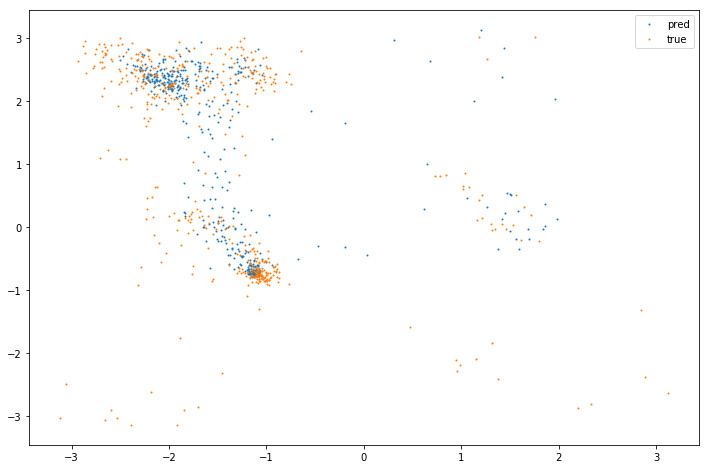

In [137]:
protein_n = 0

plt.figure(figsize=(12,8))

phi, psi, omega = np.split(pred_v, 3, -1)
plt.scatter(phi[:500], psi[:500], s=1, label='pred')

phi, psi, omega = np.split(true_dihedrals_v, 3, -1)
plt.scatter(phi[:500], psi[:500], s=1, label='true')

plt.legend()

In [ ]:
plt.hist(omega[protein_n], bins=100)

In [ ]:
#                 # access trainable variables to see if they're training
#                 variables_names = [v.name for v in tf.trainable_variables()]
#                 values = sess.run(variables_names)
#                 for k, v in zip(variables_names, values):
#                     print("Variable: ", k)
#                     print("Shape: ", v.shape)
#                     print(v)